# Import package

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle
import missingno as msno

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


# Read data

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.total_price = train.total_price.apply(np.log)

In [3]:
train.head()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469803,13.381034
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.073573,15.015913
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.462081,16.074236
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,20,1,125,1,2568,1,7271,1,99.628966,16.469809
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.131236,13.544636


In [4]:
# Increase or drop features
train['building_age'] = train.txn_dt - train.building_complete_dt
train.drop(['txn_dt', 'building_complete_dt'], axis=1, inplace=True)

In [11]:
# Change the features to categorical
train['building_material'] = train['building_material'].astype(str)
train['city'] = train['city'].astype(str)
train['town'] = train['town'].astype(str)
train['village'] = train['village'].astype(str)
train['building_type'] = train['building_type'].astype(str)
train['building_use'] = train['building_use'].astype(str)
train['parking_way'] = train['parking_way'].astype(str)
# for t in train:
#     if 'index' in t:
#         train[t] = train[t].astype(str)
mask1 = train.dtypes=='int'
mask2 = train.dtypes=='float'
mask3 = train.dtypes == 'object'
items = train.dtypes[train.columns[mask3]].index.values.tolist()
del items[0]

# Data Visualization

## Numerical features
plotting the distributions of numerical features.

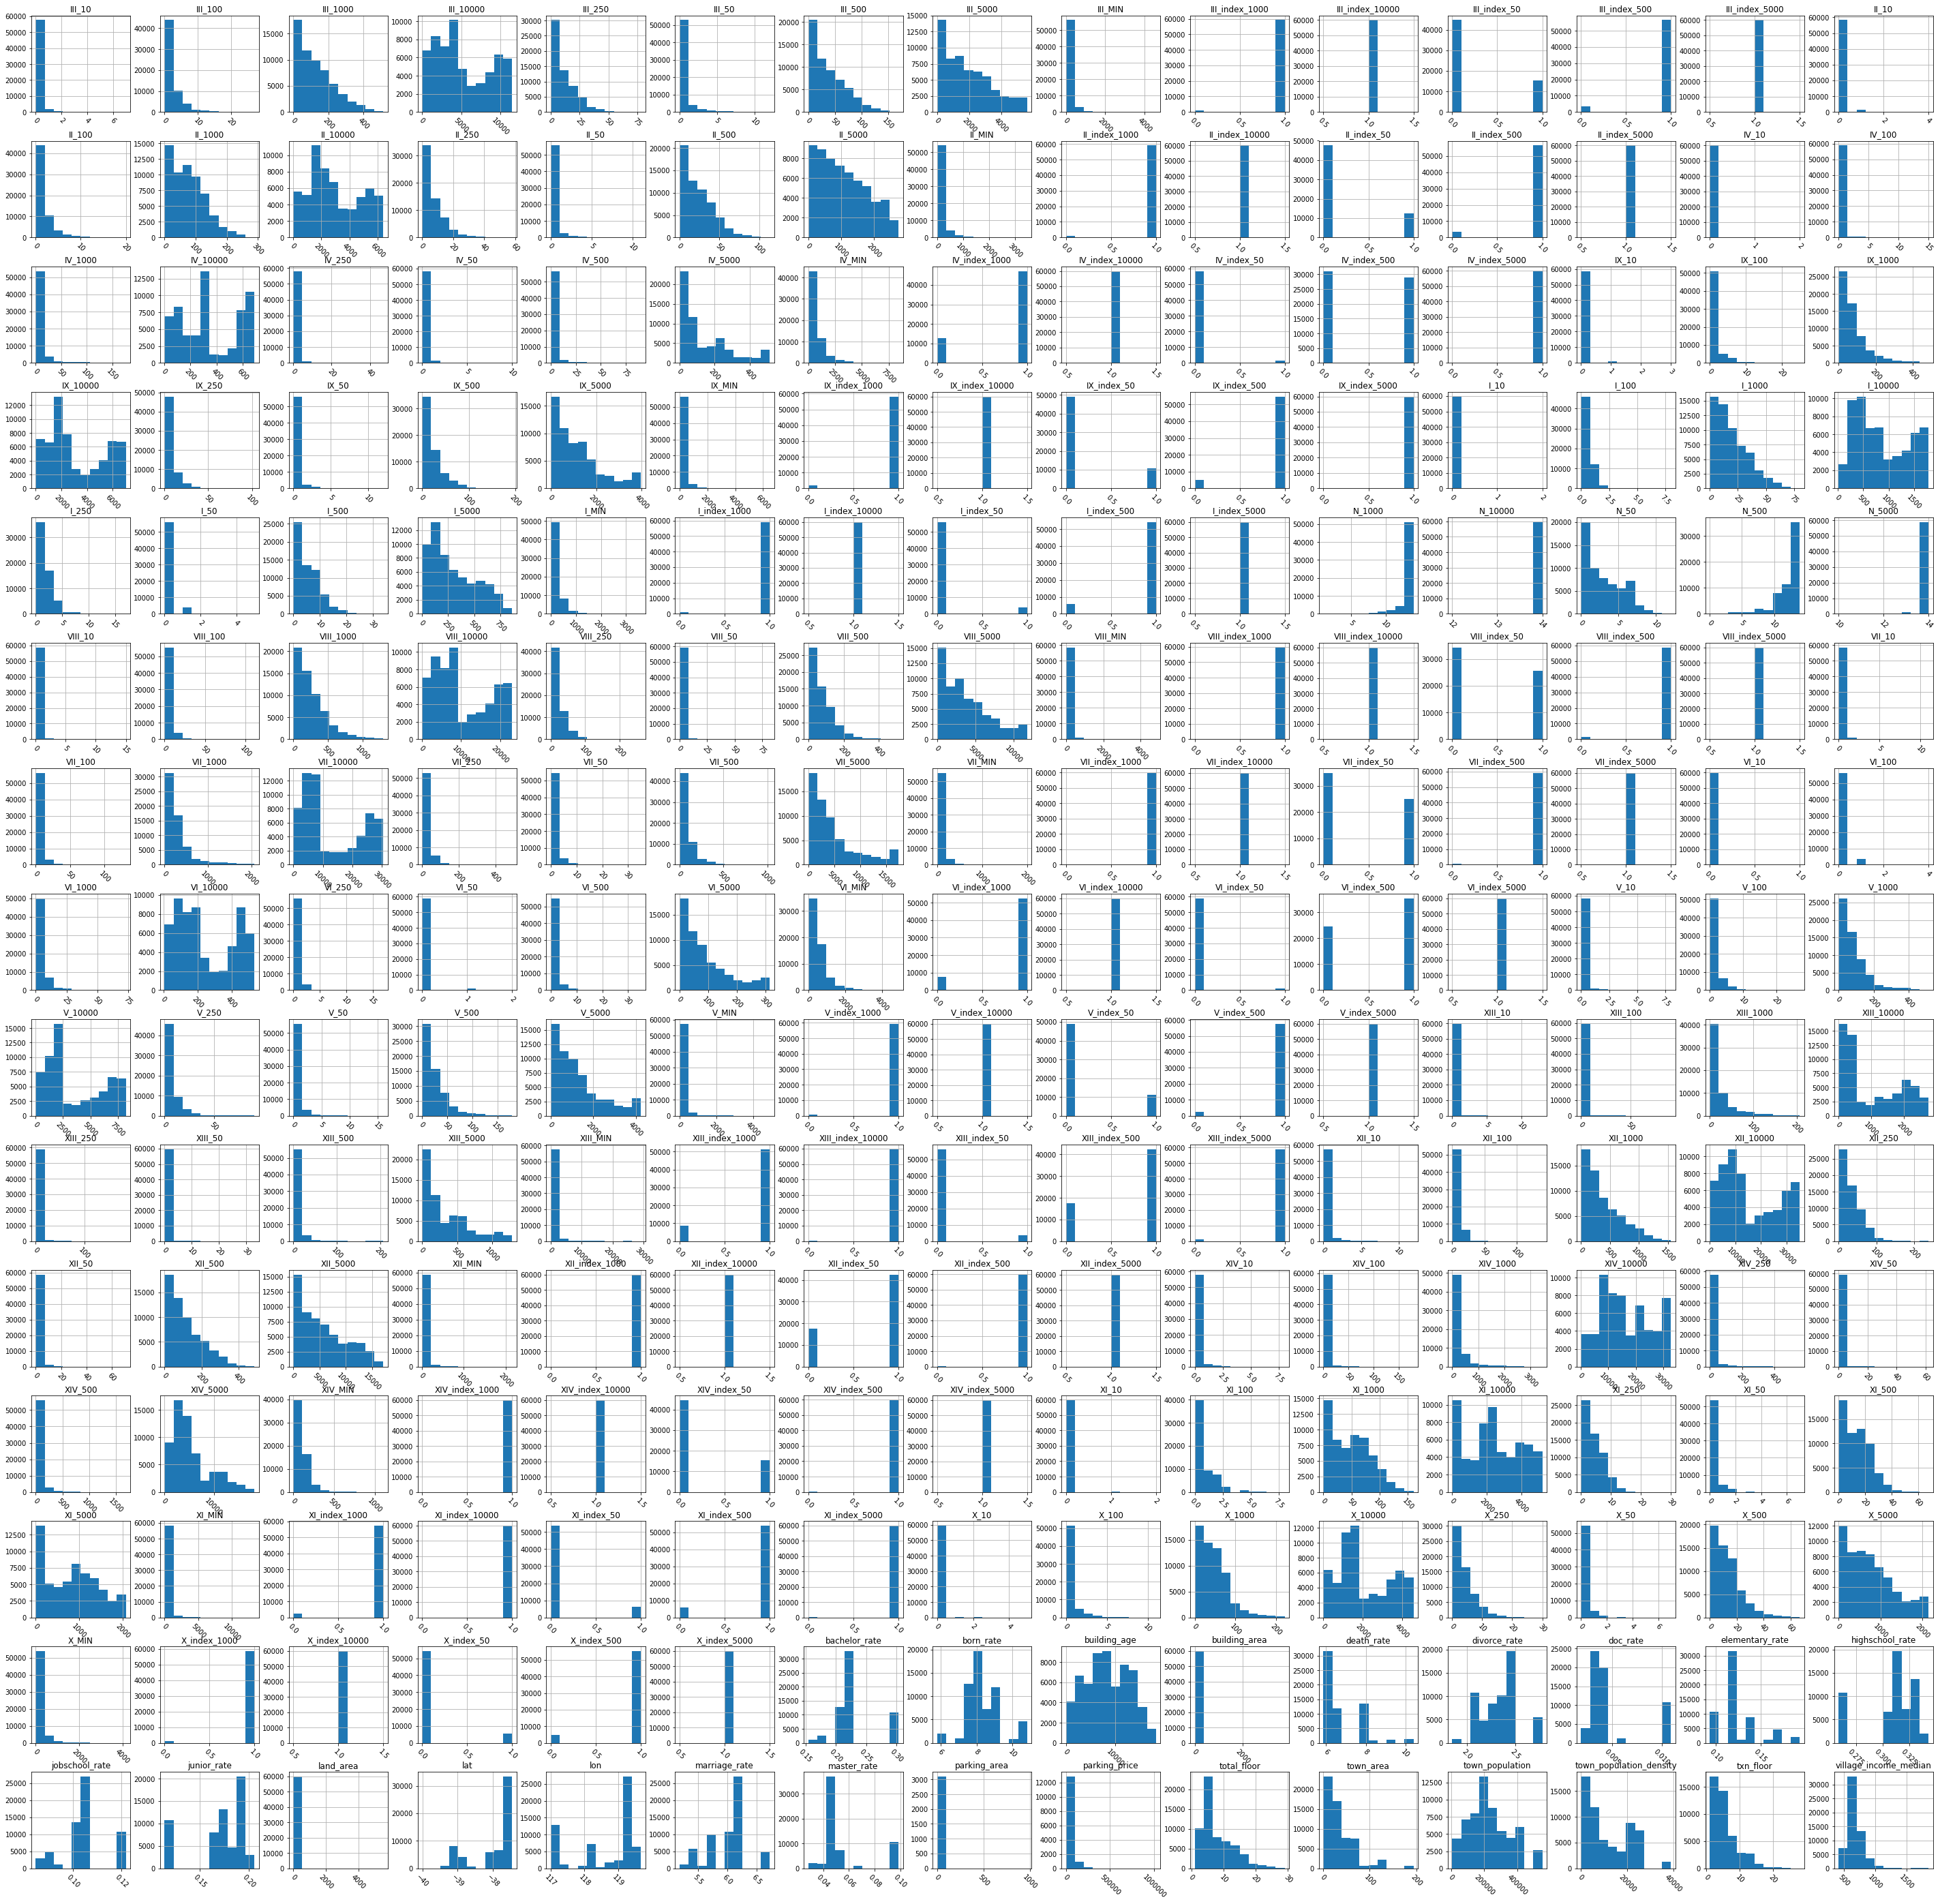

In [20]:
# Plot histogram grid

train[train.columns[(mask1|mask2)]].hist(figsize=(50,50), xrot=-45) ## Display the labels rotated by 45 degress

# Clear the text "residue"
plt.show()

## Catergorical features


['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']
7


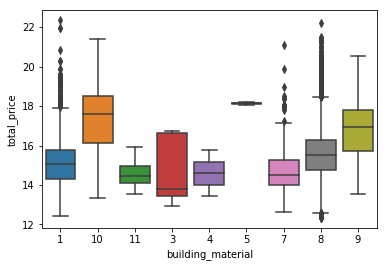

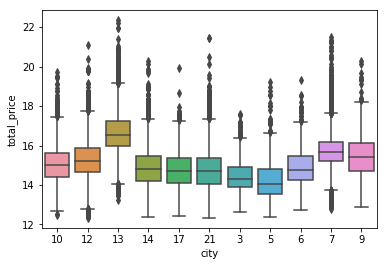

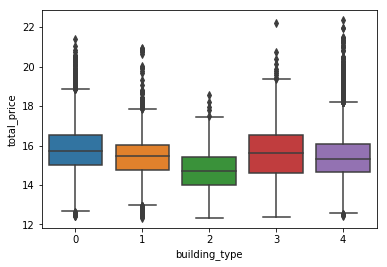

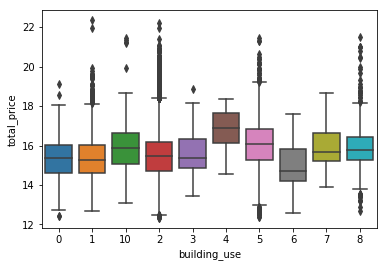

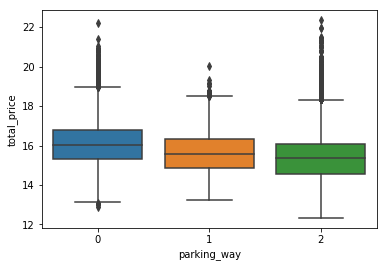

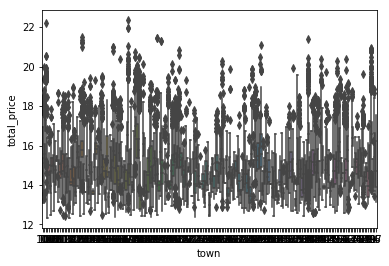

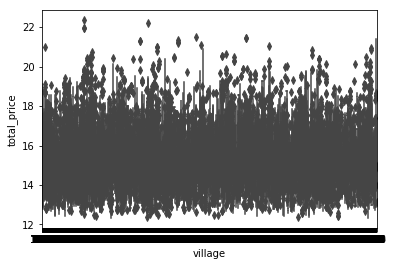

In [6]:
# train.dtypes[train.columns[mask3]].index.values.tolist()

# def boxplot(x, y, **kwargs):
#     sns.boxplot(x=x, y=y)
#     x=plt.xticks(rotation=90)
# f = pd.melt(train, id_vars=['total_price'], value_vars=train.dtypes[train.columns[mask3]].index.values.tolist())
# g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
# g = g.map(boxplot, "value", "total_price")
cols = 4
rows = len(train.dtypes[items])//cols + 1
print(items)
# fig,axes=plt.subplots(nrows=rows,ncols=cols,figsize=(30,10))
i=0
j=0
print(len(train.dtypes[items]))
for item in items:
#     axes[i,j]
    plt.figure(j)
    sns.boxplot(y='total_price', x=item, data=train)
    j+=1
#     if j== cols:
#         j=0
#         i+1


# Feature correlation
### Correlation between any two features

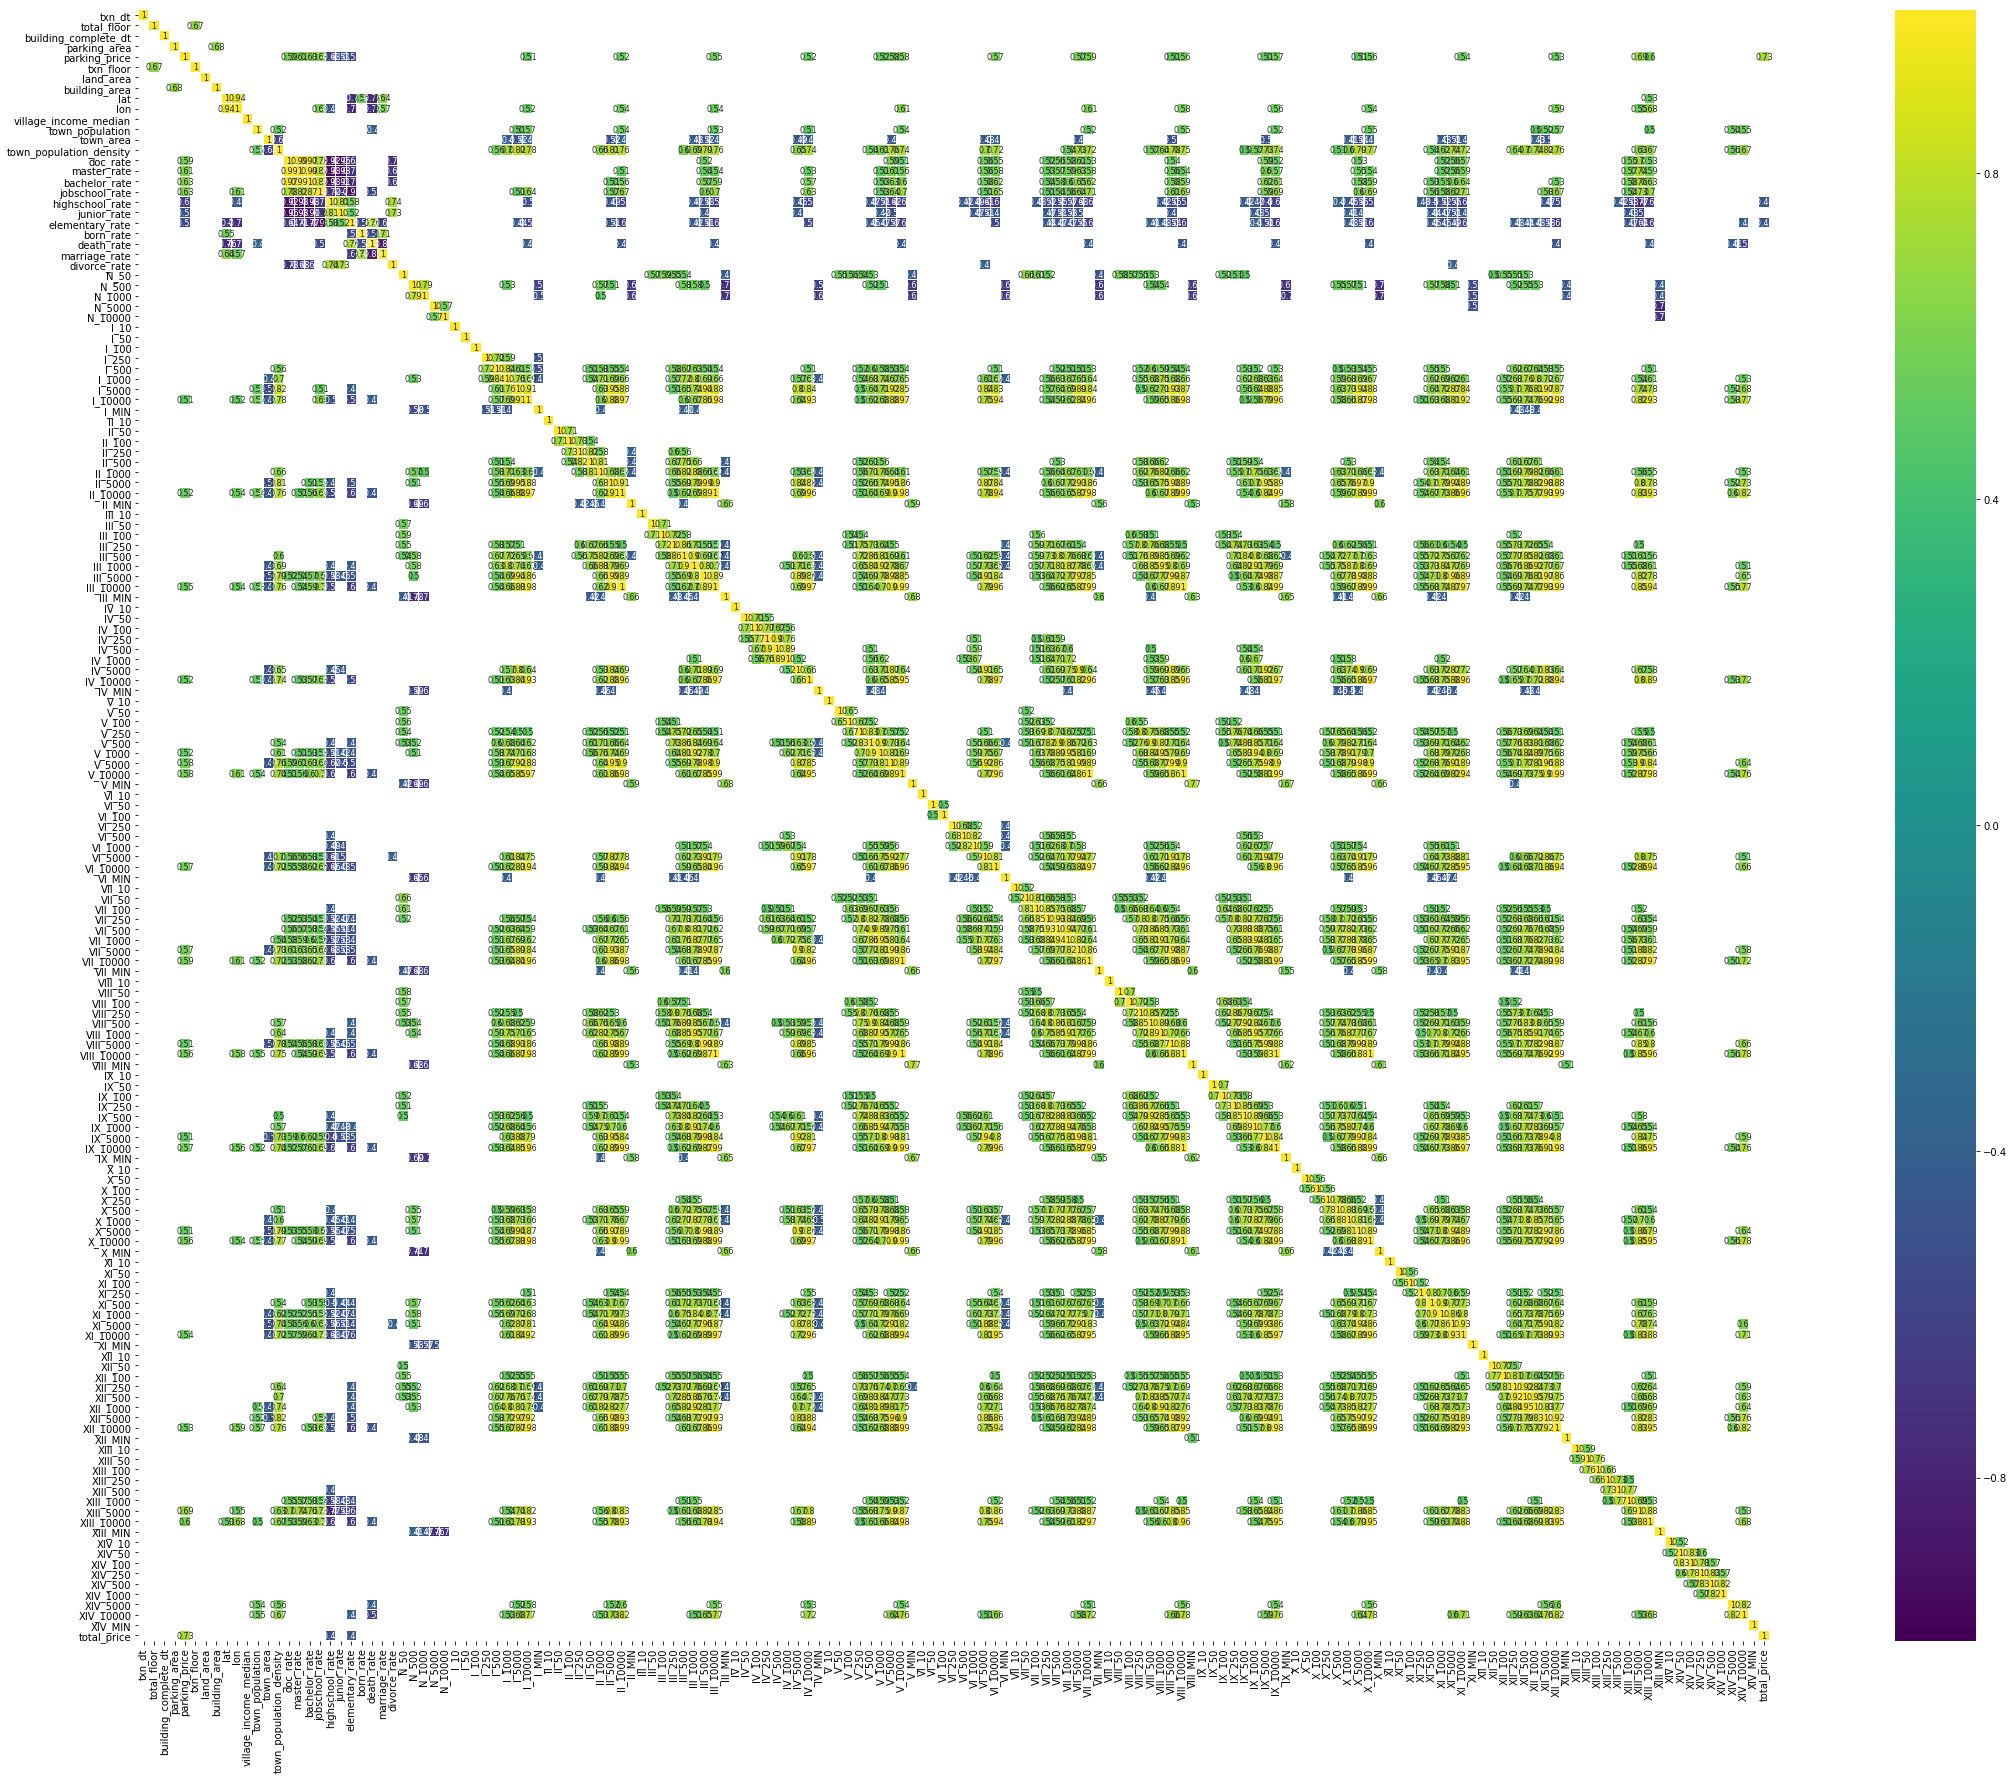

In [46]:
plt.figure(figsize=(45,30))
corr = train.corr()
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

### correlation between tatal_price and the other feastures

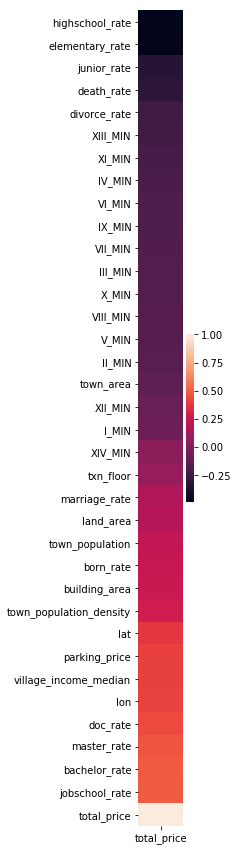

In [14]:
plt.figure(figsize=(1,15))
corr = train.corr()
sns.heatmap(train.corr()['total_price'][mask2|mask3].sort_values().to_frame())

# Feature engineering

## Converting categorical variables with target encoding
Target encoding is a fast way to get the most out of your categorical variables with little effort. The idea is quite simple. Say you can have a categorical variable `x` and a target `y`  (`y` can be binary or continuous, it doesn’t matter). For each distinct element in `x` you’re going to compute the average of the corresponding values in `y`. Then you’re going to replace each `x`<sub>i</sub> with the according mean. This is rather easy to do in Python and the pandas library.

In [7]:
def calc_target_encode(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

for item in items:
    train[item] = calc_target_encode(train, by=item, on='total_price', m=300)

## Insert missing value
### White lines indicate to missing values

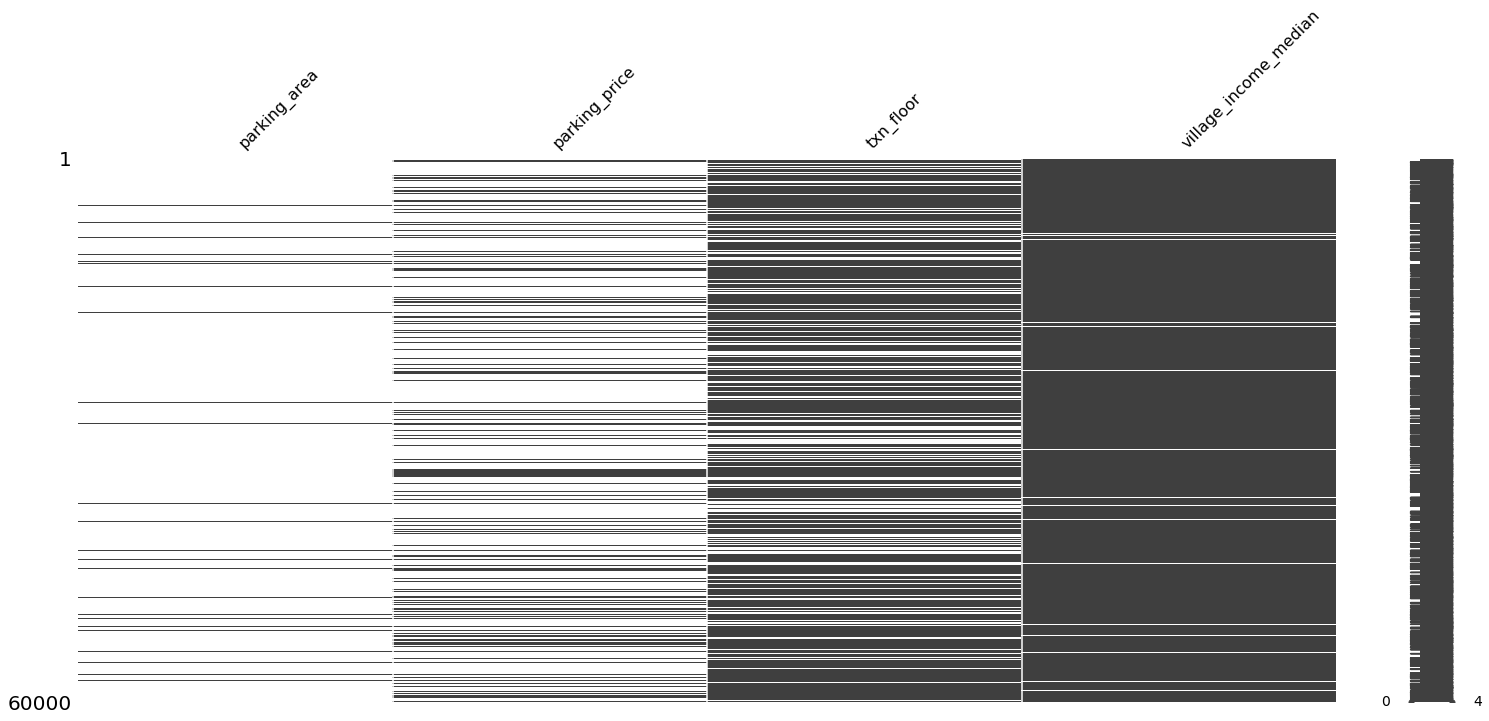

In [22]:
missingValueColumns = train.columns[train.isnull().any()].tolist()
msno.matrix(train[missingValueColumns])

In [23]:
# Find the column with missing data
NAs = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]

,Train,Test
parking_area,56897.0,9500.0
parking_price,46065.0,7710.0
txn_floor,15902.0,2639.0
village_income_median,1142.0,184.0


### The missing relationship between missing values
The missing of parking_price certainly leads to the missing of parking_area, but not the other way around

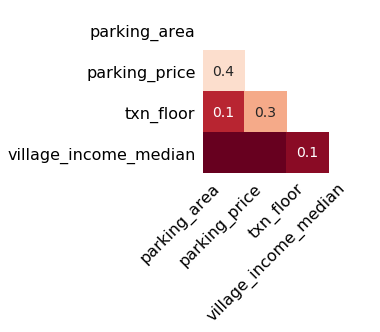

In [24]:
msno.heatmap(train[missingValueColumns],figsize=(3,3))

### Deal with parking_price and parking_area
Assume that parking_price NA means no parking space.
Drop parking_area since there are too little message.

In [8]:
for col in ('parking_price','parking_area'):
    train[col] = train[col].fillna(0)
train.drop(['parking_area'],axis=1, inplace=True)

### Deal with the other features
Use the unmissing part to predict the missing value

In [26]:
# from fancyimpute import KNN
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# X is the complete data matrix
# X_incomplete has the same values as X except a subset have been replace with NaN
# Use 3 nearest rows which have a feature to fill in each row's missing features
train.iloc[:,1:] = IterativeImputer().fit_transform(train.iloc[:,1:])

## Data pre-processing

In [12]:

numeric_features = train.loc[:,['total_floor','txn_dt','building_complete_dt','parking_area','parking_price','land_area','building_area',
                                    'village_income_median','town_population','town_area','town_population_density','master_rate','bachelor_rate','highschool_rate','jobschool_rate','junior_rate','born_rate','death_rate',
                                    'marriage_rate','divorce_rate']]
numeric_features_standardized = (numeric_features - numeric_features.mean())/numeric_features.std()

In [13]:
### Copying features
features_standardized = train.copy()

### Replacing numeric features by standardized values
features_standardized.update(numeric_features_standardized)

In [14]:
train_features_st = features_standardized.drop('building_id', axis=1).select_dtypes(include=[np.number]).values

In [15]:
### Shuffling train sets
train_features_st, train_features, train_labels = shuffle(train_features_st, train_features, train_labels, random_state = 5)

NameError: name 'train_features' is not defined

In [ ]:
x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(train_features_st, train_labels, test_size=0.1, random_state=200)

In [ ]:
GBest = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber').fit(x_train, y_train)
train_test(GBest, x_train_st, x_test_st, y_train_st, y_test_st)

# Model structure

In [9]:
class AttentionModel(nn.Module):
    def __init__(self, input_size, extract_size=128, H1=1000, H2=500, H3=200, output_size=1):
        super(AttentionModel, self).__init__()
        self.input_size = input_size
        self.compress = nn.Sequential(
            nn.Linear(input_size, extract_size),
            nn.Tanh()
        )
        self.att = []
        for i in range(input_size):
            self.att.append(nn.Sequential(
                nn.Linear(input_size, 2),
                nn.Softmax()
            ))
        self.learn = nn.Sequential(
            self.linear1 = nn.Linear(input_size, H1)
            self.linear2 = nn.Linear(H1, H2)
            self.linear3 = nn.Linear(H2, H3)
            self.linear4 = nn.Linear(H3, D_out)
        )

    def forward(self, x):
        comp = self.compress(x)
        attention_out = []
        for i in range(self.input_size):
            out = self.att[i](comp)
            attention_out.append(out[:,1])
        torch.stack(attention_out,dim=0)
        return attention_out
    
class Net(nn.Module):
    def __init__(self, input_size, H1, H2, H3, output_size=1):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)
        
    def forward(self, x):
        y_pred = self.linear1(x).clamp(min=0)
        y_pred = torch.nn.functional.dropout(y_pred, p=0.2)
        y_pred = self.linear2(y_pred).clamp(min=0)
        y_pred = torch.nn.functional.dropout(y_pred, p=0.2)
        y_pred = self.linear3(y_pred).clamp(min=0)
        y_pred = torch.nn.functional.dropout(y_pred, p=0.2)
        y_pred = self.linear4(y_pred)
        return y_pred

In [21]:
def train(args):
    os.makedirs(args.ckpt_dir, exist_ok=True)
    writer = SummaryWriter('log')
    dataloader = create_dataloader(args.train_data, train=True)
    model = LinearModel(args.input_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, betas=(args.b1, args.b2))
    criterion = torch.nn.MSELoss()

    tqdm.write('[*] Start training')
    step = 0
    epoch_bar = tqdm(range(args.n_epochs), desc='[Total Progress]', dynamic_ncols=True, leave=False, position=0)
    for epoch in epoch_bar:
        batch_bar = tqdm(dataloader, desc='[Train epoch {:2}]'.format(epoch), dynamic_ncols=True, leave=False, position=1)
        for i, data in enumerate(batch_bar):
            feature, label = data['feature'], data['label']
            optimizer.zero_grad()
            pred = model(feature)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

            hitRate = hit_rate(pred, label)
            if (step % 100 == 0):
                batch_bar.set_description('[Batch {}/{}] loss: {} hit_rate: {}'.format(i, len(dataloader), loss, hitRate))
                writer.add_scalar('Loss', loss, step)
            if (step % args.save_fq == 0):
                save_path = os.path.join(args.ckpt_dir, '{}.ckpt'.format(step))
                save_model(model, save_path)
            step += 1


    tqdm.write('[*] Finish training')
    return 

torch.Size([4, 3])
